<a href="https://colab.research.google.com/github/Masciel-Sevilla/Segmentacion/blob/main/PrediccionesFormatoCorrecto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

✅ Cargando modelo desde: efficient_weed_model_B0_best.keras
✅ Modelo cargado exitosamente.
🧠 Realizando predicciones en un lote aleatorio...
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
🎨 Generando visualización...


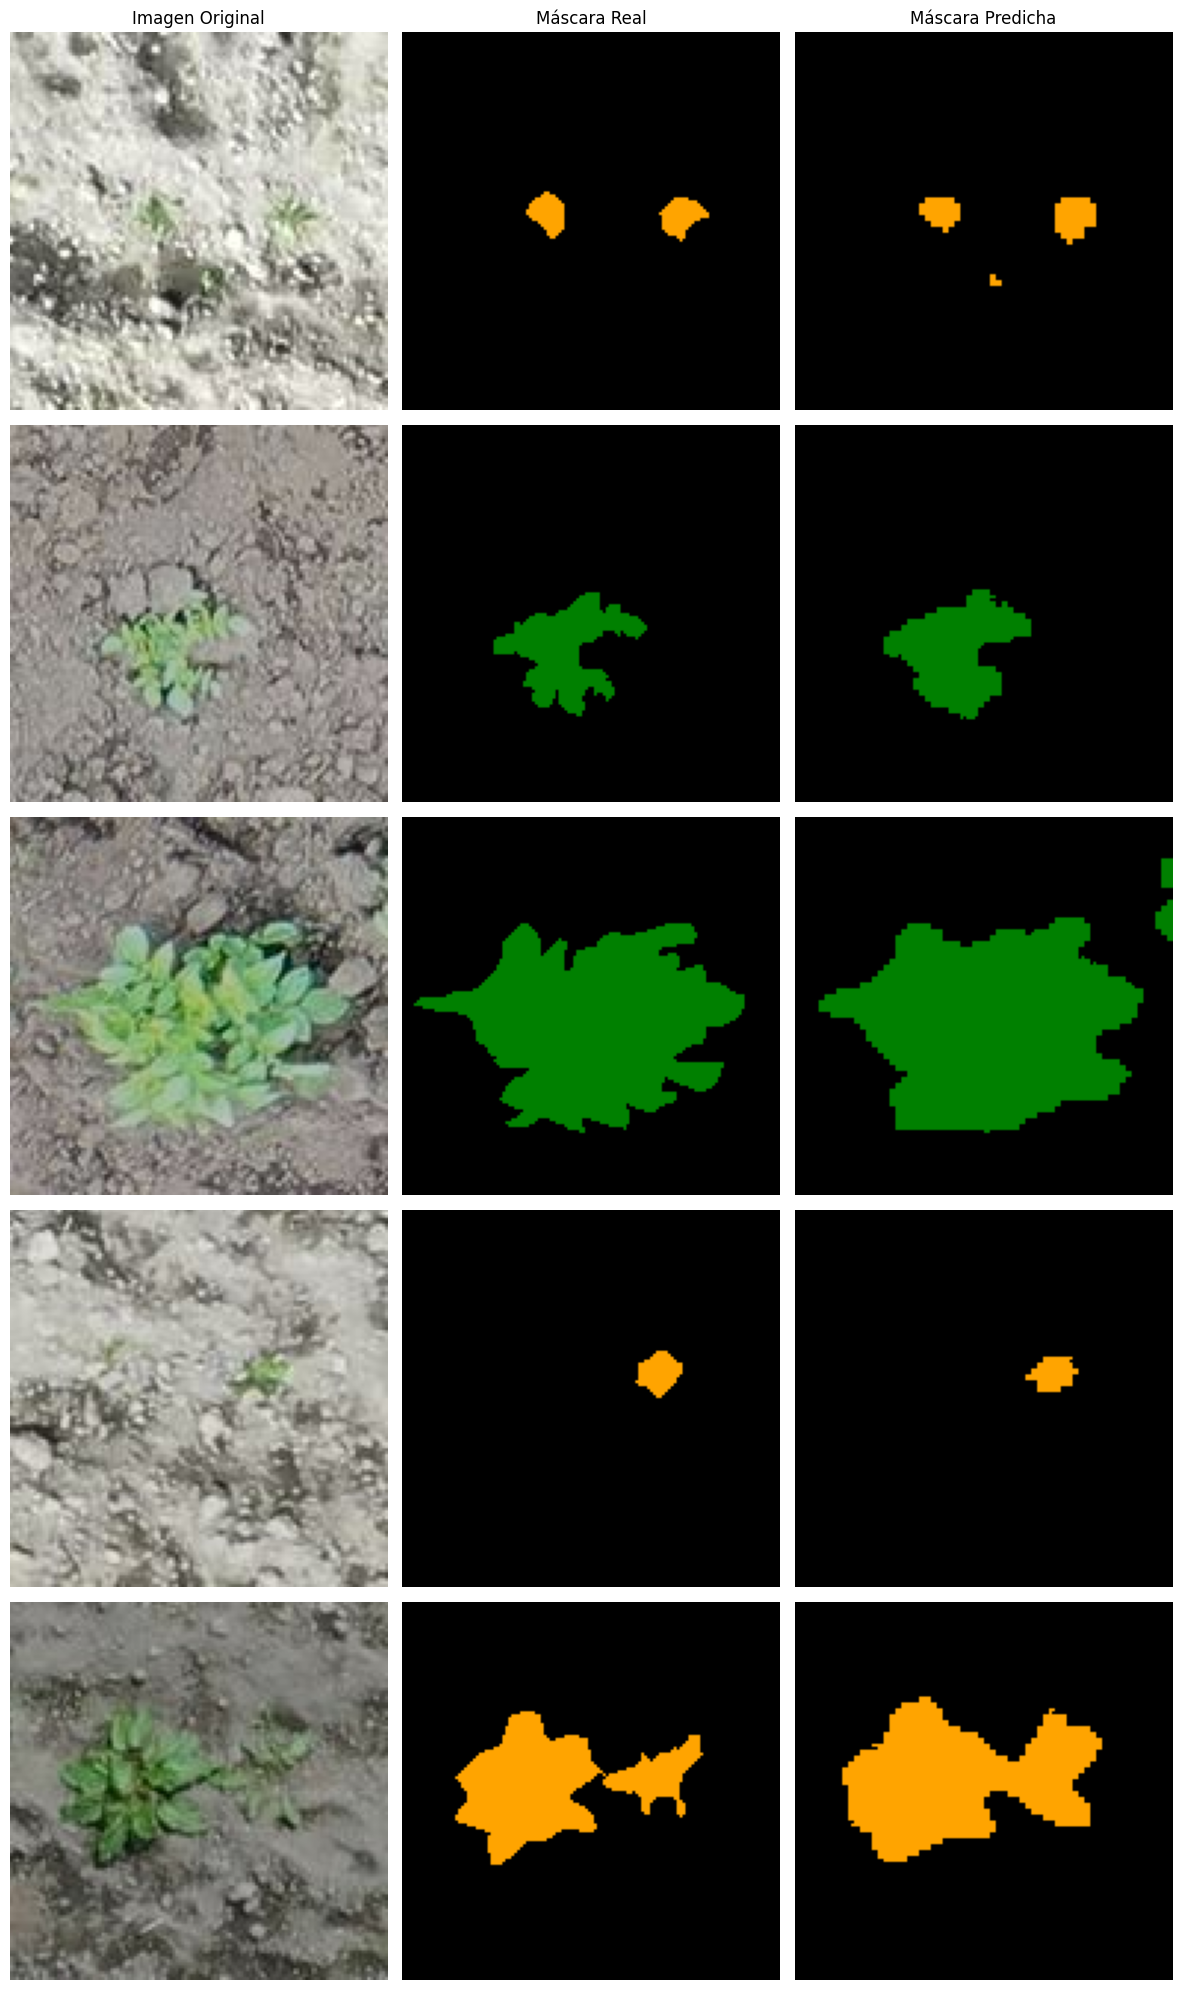

In [5]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import os
from glob import glob
import random

# --- 1. CONFIGURACIÓN ---
MODEL_PATH = 'efficient_weed_model_B0_best.keras'
BASE_PATH = './Balanced'
IMG_HEIGHT = 128
IMG_WIDTH = 128
NUM_CLASSES = 6
BATCH_SIZE = 5 # Cantidad de imágenes aleatorias a mostrar

# --- 2. DEFINICIONES DEL MODELO (Necesario para cargar) ---

class ASPPModule(layers.Layer):
    def __init__(self, filters=192, **kwargs):
        super(ASPPModule, self).__init__(**kwargs)
        self.filters = filters
        self.conv_1x1 = layers.Conv2D(filters, 1, padding='same', use_bias=False)
        self.bn_1x1 = layers.BatchNormalization()
        self.relu_1x1 = layers.ReLU()
        self.conv_3x3_6 = layers.Conv2D(filters, 3, padding='same', dilation_rate=6, use_bias=False)
        self.bn_3x3_6 = layers.BatchNormalization()
        self.relu_3x3_6 = layers.ReLU()
        self.conv_3x3_12 = layers.Conv2D(filters, 3, padding='same', dilation_rate=12, use_bias=False)
        self.bn_3x3_12 = layers.BatchNormalization()
        self.relu_3x3_12 = layers.ReLU()
        self.conv_3x3_18 = layers.Conv2D(filters, 3, padding='same', dilation_rate=18, use_bias=False)
        self.bn_3x3_18 = layers.BatchNormalization()
        self.relu_3x3_18 = layers.ReLU()
        self.global_avg_pool = layers.GlobalAveragePooling2D(keepdims=True)
        self.conv_1x1_gap = layers.Conv2D(filters, 1, padding='same', use_bias=False)
        self.bn_1x1_gap = layers.BatchNormalization()
        self.relu_1x1_gap = layers.ReLU()
        self.conv_final = layers.Conv2D(filters, 1, padding='same', use_bias=False)
        self.bn_final = layers.BatchNormalization()
        self.relu_final = layers.ReLU()
        self.dropout = layers.Dropout(0.2)
    def call(self, inputs, training=None):
        input_shape = tf.shape(inputs)
        conv_1x1 = self.relu_1x1(self.bn_1x1(self.conv_1x1(inputs), training=training))
        conv_3x3_6 = self.relu_3x3_6(self.bn_3x3_6(self.conv_3x3_6(inputs), training=training))
        conv_3x3_12 = self.relu_3x3_12(self.bn_3x3_12(self.conv_3x3_12(inputs), training=training))
        conv_3x3_18 = self.relu_3x3_18(self.bn_3x3_18(self.conv_3x3_18(inputs), training=training))
        gap = self.global_avg_pool(inputs)
        gap = self.relu_1x1_gap(self.bn_1x1_gap(self.conv_1x1_gap(gap), training=training))
        gap = tf.image.resize(gap, [input_shape[1], input_shape[2]], method='bilinear')
        concat = layers.Concatenate()([conv_1x1, conv_3x3_6, conv_3x3_12, conv_3x3_18, gap])
        output = self.relu_final(self.bn_final(self.conv_final(concat), training=training))
        output = self.dropout(output, training=training)
        return output

class DeformableAttention(layers.Layer):
    def __init__(self, filters, **kwargs):
        super(DeformableAttention, self).__init__(**kwargs)
        self.filters = filters
    def build(self, input_shape):
        self.attention_conv = layers.Conv2D(self.filters, 1, padding='same', activation='sigmoid', name='attention_weights_conv', use_bias=False)
        self.bn_attention = layers.BatchNormalization()
        self.feature_conv = layers.SeparableConv2D(self.filters, 3, padding='same', name='feature_processing_conv', use_bias=False)
        self.bn_feature = layers.BatchNormalization()
        self.relu_feature = layers.ReLU()
        super(DeformableAttention, self).build(input_shape)
    def call(self, inputs, training=None):
        attention_weights = self.bn_attention(self.attention_conv(inputs), training=training)
        features = self.relu_feature(self.bn_feature(self.feature_conv(inputs), training=training))
        attended_features = features * attention_weights
        return attended_features

# Funciones dummy para poder cargar el modelo
def dice_coefficient(y_true, y_pred, smooth=1e-6): return 0.0
def iou_metric(y_true, y_pred): return 0.0
def combined_loss(y_true, y_pred): return 0.0

# --- 3. FUNCIÓN DE VISUALIZACIÓN (CORREGIDA) ---
def plot_sample_masks(images, true_masks, pred_masks, num_samples):
    """Visualiza la imagen, máscara real y máscara predicha."""

    # **LA CORRECCIÓN DEFINITIVA ESTÁ AQUÍ**
    # Basado en tu diagnóstico, sabemos que 'images' llega en el rango [0, 255].
    # Simplemente lo convertimos al rango [0, 1] que Matplotlib espera.
    images_to_show = images.astype('uint8')

    # El resto del código para visualizar
    colors = [
        [0, 0, 0], [0, 0, 1], [1, 0.647, 0], [1, 1, 0], [0.502, 0, 0.502], [0, 0.502, 0]
    ]
    custom_cmap = ListedColormap(colors)
    true_masks_indices = np.argmax(true_masks, axis=-1)
    pred_masks_indices = np.argmax(pred_masks, axis=-1)

    fig, axes = plt.subplots(num_samples, 3, figsize=(12, num_samples * 4))
    if num_samples == 1: axes = np.expand_dims(axes, axis=0)

    axes[0, 0].set_title("Imagen Original", fontsize=12)
    axes[0, 1].set_title("Máscara Real", fontsize=12)
    axes[0, 2].set_title("Máscara Predicha", fontsize=12)

    for i in range(num_samples):
        axes[i, 0].imshow(images_to_show[i])
        axes[i, 0].axis('off')
        axes[i, 1].imshow(true_masks_indices[i], cmap=custom_cmap, vmin=0, vmax=NUM_CLASSES-1)
        axes[i, 1].axis('off')
        axes[i, 2].imshow(pred_masks_indices[i], cmap=custom_cmap, vmin=0, vmax=NUM_CLASSES-1)
        axes[i, 2].axis('off')
    plt.tight_layout()
    plt.show()

# --- 4. FUNCIÓN PARA CARGAR DATOS ---
def load_and_preprocess_for_visualization(image_path, mask_path):
    # Carga la imagen y máscara SIN pre-procesamiento para visualización
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3, expand_animations=False)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, [IMG_HEIGHT, IMG_WIDTH], method='nearest')
    mask = tf.one_hot(tf.squeeze(tf.cast(mask, tf.int32)), NUM_CLASSES)

    # Crea una versión pre-procesada SÓLO para el modelo
    image_for_model = tf.keras.applications.efficientnet_v2.preprocess_input(tf.cast(image, tf.float32))

    return tf.cast(image, tf.uint8), mask, image_for_model

# --- 5. EJECUCIÓN PRINCIPAL ---
if __name__ == "__main__":
    print(f"✅ Cargando modelo desde: {MODEL_PATH}")
    custom_objects = {
        'ASPPModule': ASPPModule, 'DeformableAttention': DeformableAttention,
        'combined_loss': combined_loss, 'dice_coefficient': dice_coefficient, 'iou_metric': iou_metric
    }
    model = tf.keras.models.load_model(MODEL_PATH, custom_objects=custom_objects)
    print("✅ Modelo cargado exitosamente.")

    TEST_IMAGES_PATH = os.path.join(BASE_PATH, 'test/images')
    TEST_MASKS_PATH = os.path.join(BASE_PATH, 'test/masks')
    test_image_paths = sorted(glob(os.path.join(TEST_IMAGES_PATH, '*.jpg')))
    test_mask_paths = sorted(glob(os.path.join(TEST_MASKS_PATH, '*.png')))

    if not test_image_paths:
        print("❌ Error: No se encontraron imágenes de test.")
    else:
        paired_paths = list(zip(test_image_paths, test_mask_paths))
        random.shuffle(paired_paths)

        # Seleccionamos un lote de imágenes para procesar
        batch_paths = paired_paths[:BATCH_SIZE]

        # Preparamos los lotes para el modelo y la visualización
        images_for_viz = []
        masks_for_viz = []
        images_for_model_list = []

        for img_path, mask_path in batch_paths:
            img_viz, mask_viz, img_model = load_and_preprocess_for_visualization(img_path, mask_path)
            images_for_viz.append(img_viz.numpy())
            masks_for_viz.append(mask_viz.numpy())
            images_for_model_list.append(img_model.numpy())

        # Convertimos las listas a arrays de numpy
        images_batch_viz = np.array(images_for_viz)
        masks_batch_viz = np.array(masks_for_viz)
        images_batch_model = np.array(images_for_model_list)

        print("🧠 Realizando predicciones en un lote aleatorio...")
        predictions_batch = model.predict(images_batch_model)

        print("🎨 Generando visualización...")
        plot_sample_masks(images_batch_viz, masks_batch_viz, predictions_batch, num_samples=BATCH_SIZE)

In [1]:
# Paso 1: Descomprimir el dataset (esto solo se hace una vez)
import os
import zipfile

zip_path = '/content/Balanced.zip'
extract_path = '/content/'

# Solo descomprimir si no se ha hecho antes
if not os.path.exists(os.path.join(extract_path, 'Balanced')):
    print(f"Descomprimiendo {zip_path}...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("¡Descompresión completada!")
else:
    print("La carpeta 'Balanced' ya existe. Omitiendo descompresión.")

Descomprimiendo /content/Balanced.zip...
¡Descompresión completada!
